In [ ]:
from google.colab import drive
import os
drive.mount(r'/content/gdrive/')
os.chdir('/content/gdrive/MyDrive/simulacion_agentes')

Mounted at /content/gdrive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Quiero hacer un modelo de agentes en el que cada persona es una variable e interactuan en 3 niveles de sociabilizacion: vivienda, trabajo/escuela y resto del mundo.

In [ ]:
#Defino vectores que contienen las caracteristicas de los agentes.
N=600000 #Numero de agentes
N_e=30
N_t=30
N_c=4
id=np.arange(0,N) #identificaciones de los agentes
edad=np.array([0,1]*(N//2))# 0=niños, 1=adultos

In [ ]:
#Voy a definir el nivel 1, es decir las casas, tendré 120000/4 casas
casas=np.array(np.array_split(id, N/N_c))
#Voy a definir el nivel 2 con los trabajos y las escuelas, tendre 120000/30
escuelas=np.array(np.array_split(np.array([i for i in np.random.RandomState(seed=42).permutation(id) if i%2==0]), N/(2*N_e)))
trabajos=np.array(np.array_split([i for i in np.random.RandomState(seed=42).permutation(id) if i%2==1], N/(2*N_t)))
#Voy a definir el nivel 3, resto del mundo en 4 secciones
resto=np.array(np.array_split(id, 4))

### Voy a intentar definir los contactos posibles en cada uno de los niveles.


Una persona en el nivel 1 vive con sus 3 familiares y por ende tendra siempre 3 contactos, aunque ese contacto va a depende de la edad que tenga. Si es edad(niño)=0 tendrá contactos del tipo (n-n, n-a, n-a), si es adulto edad(adulto)=1 tendra contactos del tipo (a-a, a-n, a-n)

Tengo que poder definir una funcion que me devuelva el tiempo de contactos entre dos personas que viven en una misma casa solo pasandole el id de la persona, esto seria conocer los contactos entre personas en el nivel 1.

In [ ]:
#Matriz de edades
a_n=60
a_a=4*60
n_n=4*60
m_edad=np.array([[n_n, a_n], [a_n, a_a]])

In [ ]:
m_edad

array([[240,  60],
       [ 60, 240]])

In [ ]:
def dur_1(id_1, id_2, m_edad):
    '''Pre: Toma dos valores de ids que representan a dos agentes.
       Pos: Calcula la duracion del contacto entre esos agentes. Si la diferencia entre ids es mayor
            a 3 implica que no viven en la misma casa y si la diferencia es 0 implica que es la misma 
            persona, en ambos casos se toma un tiempo de contacto igual a 0 minutos.
    '''
    r=None
    casa1=id_1//4
    casa2=id_2//4
    
    if ( (id_1==id_2) or (casa1 != casa2) ):
        r=0
    else:
        r=m_edad[edad[id_1], edad[id_2]]
        
    return r
    

Quiero definir una matriz de matrices para tener guardados los contactos entre personas de las mismas escuelas

In [ ]:
m_esc=np.zeros((N//(2*N_e),N_e,N_e))
tiempos_es=[0,5,20] #Defino los tiempos de contactos
prob_es=[0.1,0.6,0.3] # Probabilidad de tener un determinado tiempo
for e, escuela in enumerate(escuelas):
    #esc=list(escuelas[escuela]) #Transrormo en lista para obtener el indice del agente
    #Fijo una semilla aleatoria para todos los contactos que son 29*(29+1)/2
    #dicha semilla viene dada por la escuela a la cual pertecenen
    #np.random.seed(e)
    #vector que contiene los contactos (son 435)
    cont_e=np.random.choice(a=tiempos_es, size=435, p=prob_es)
    #Creo la matriz de contactos, primero llena de ceros
    #Ahora asigno los contactos
    k=0 #contador que va aumentando cada vez que reasigno un valor de la matriz
    for i in range(len(escuela)):
        for j in range(i+1, len(escuela)):
            m_esc[e,i,j]=cont_e[k]
            k+=1
    m_esc[e]=(m_esc[e] +m_esc[e].T) #Simetrizo la matriz
    

Quiero definir una matriz de matrices para tener guardados los contactos entre personas de los mismos trabajos

In [ ]:
m_tra=np.zeros((N//(2*N_t),N_t,N_t))
tiempos_tr=[0,5,20] #Defino los tiempos de contactos
prob_tr=[0.2,0.5,0.3] # Probabilidad de tener un determinado tiempo
for t, trabajo in enumerate(trabajos):
    #esc=list(escuelas[escuela]) #Transrormo en lista para obtener el indice del agente
    #Fijo una semilla aleatoria para todos los contactos que son 29*(29+1)/2
    #dicha semilla viene dada por la escuela a la cual pertecenen
    np.random.seed(t)
    #vector que contiene los contactos (son 435)
    cont_t=np.random.choice(a=tiempos_tr, size=435, p=prob_tr)
    #Creo la matriz de contactos, primero llena de ceros
    #Ahora asigno los contactos
    k=0 #contador que va aumentando cada vez que reasigno un valor de la matriz
    for i in range(len(trabajo)):
        for j in range(i+1, len(trabajo)):
            m_tra[t,i,j]=cont_t[k]
            k+=1
    m_tra[t]=(m_tra[t] +m_tra[t].T) #Simetrizo la matriz


In [ ]:
np.save('m_trabajos_500.npy', m_tra)

In [ ]:
np.save('m_escuelas_500.npy', m_esc)

In [ ]:
#Cargo las matrices de 3 indices que tienen guardados los contactos en escuelas y en los trabajos
m_esc=(np.load('m_escuelas_500.npy')/1440)
m_tra=(np.load('m_trabajos_500.npy')/1440)

Defino la tercera funcion que asignara 5 contactos por dia de 10 minutos a los adultos y 5 contactos por dia de 2 minutos a los niños

In [ ]:
def dur_3(id):
    barrio=id//(N//4)
    if edad[id]==0:
        tiempos_n=[2,5,10] #Defino los tiempos de contactos
        prob_n=[0.4,0.4,0.2] # Probabilidad de tener un determinado tiempo
        cont_n=np.random.choice(a=tiempos_n, size=4, p=prob_n)
        personas_n=np.random.choice(resto[barrio], size=4)
    else:
        tiempos_n=[2,5,10] #Defino los tiempos de contactos
        prob_n=[0.4,0.4,0.2] # Probabilidad de tener un determinado tiempo
        cont_n=np.random.choice(a=tiempos_n, size=10, p=prob_n)
        personas_n=np.random.choice(resto[barrio], size=10)
    return [list(a) for a in zip(cont_n, personas_n)]

In [ ]:
dur_3(1288)

[[10, 37782], [2, 16883], [5, 24699], [10, 64904]]

In [ ]:
def dinamica(p,dias, c_i):
    from tqdm import tqdm
    #Defino el vector de estados
    estados=np.zeros(N)
    c_i=c_i
    np.random.seed(42)
    inf_in=np.random.choice(N, size=c_i)
    dias_inf=np.random.choice(range(1,10), size=c_i)

    for persona in inf_in:
        estados[persona]=1

    #Defino el vector de infectados, sus elementos son sublistas con primer elemento id y segundo elemento numero de dia cursando la 
    #enfermedad
    infectados=[list(a) for a in zip(inf_in, dias_inf) ]

    dias=dias
    t_inf=10

    n_suc=np.zeros(dias)
    n_inf=np.zeros(dias)
    n_rec=np.zeros(dias)
    #estado=np.zeros([dias,N])

    for dia in tqdm(range(dias)): #loop para los dias de simulacion
        nuevos=[]
        for inf in infectados: #loop para recorrer los infectados inf
            casa=inf[0]//4 #Defino la casa en la que vive el infectado
            for i in casas[casa]: #agregar probabilidad, aca estoy supoineindo p=1
                if estados[i]==0:
                    prob_c=1-np.exp(-p*dur_1(inf[0],i,m_edad)/(1440))
                    random_c=np.random.random()
                    if random_c < prob_c:
                        nuevos.append([i,1])
                        estados[i]=1
            if edad[inf[0]]==0:
                busco=np.where(escuelas==inf[0])
                escuela=busco[0][0]
                persona=busco[1][0]
                for index, contacto in enumerate(escuelas[escuela]):
                    if estados[contacto]==0:
                        prob_es=1-np.exp(-p*m_esc[escuela,persona, index])
                        random_es=np.random.random()
                        if random_es < prob_es:
                            nuevos.append([contacto,1])
                            estados[contacto]=1
            else:
                busco=np.where(trabajos==inf[0])
                trabajo=busco[0][0]
                persona=busco[1][0]
                for index, contacto in enumerate(trabajos[trabajo]):
                    if estados[contacto]==0:
                        prob_tr=1-np.exp(-p*m_tra[trabajo,persona, index])
                        random_tr=np.random.random()
                        if random_tr < prob_tr:
                            nuevos.append([contacto,1])
                            estados[contacto]=1

            resto=dur_3(inf[0]) #[(2, 11324), (5, 21544), (5, 4448), (2, 1933)]
            for k,l in resto:
                #print(resto)
                if estados[l]==0:
                    prob_r=1-np.exp(-(p*k)/1440)
                    random_r=np.random.random()
                    if random_r < prob_r:
                        nuevos.append([l,1])
                        estados[l]=1
            inf[1]=inf[1]+1
            if inf[1]>t_inf: #cambiar 10 por t_inf
                estados[inf[0]]=2 #pasa a recuperado
                #del inf #sacalo del vector de infectados
        infectados[:]=[inf for inf in infectados if not inf[1]>t_inf]
        infectados=infectados+nuevos
        #print(infectados)
        n_suc[dia]=np.sum(estados==0)
        n_inf[dia]=np.sum(estados==1)
        n_rec[dia]=np.sum(estados==2)
        #estado[dia]=estados
    print(len(infectados))
    return [n_suc, n_inf, n_rec]
    

In [ ]:
results=[]
for p in np.arange(0.1,1.1,0.1):
    results.append(dinamica(p,250,500))
    

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 27.87it/s]


0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 15.69it/s]


0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:00<00:00,  1.04it/s]


720


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:40:34<00:00, 24.14s/it]


81


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [2:15:45<00:00, 32.58s/it]


0


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [2:32:08<00:00, 36.51s/it]


0


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [2:40:48<00:00, 38.59s/it]


0


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [2:43:46<00:00, 39.30s/it]


0


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [2:45:49<00:00, 39.80s/it]


0


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [2:49:22<00:00, 40.65s/it]

0


In [ ]:
#np.save('results_nuevo_600.npy', results)

In [ ]:
results=np.load('results_nuevo_600.npy')

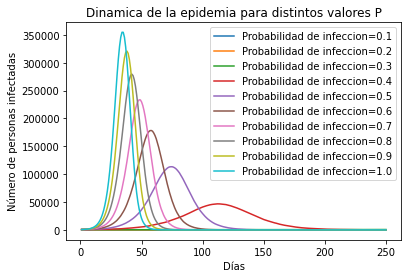

In [ ]:
#interactive plotting in separate window
plt.figure(1)
#%matplotlib qt 
for i in range(len(results)):
  plt.plot(range(1,250+1), results[i][1], label=f'Probabilidad de infeccion={(i+1)/10}')
plt.xlabel('Días')
plt.ylabel('Número de personas infectadas')
plt.title('Dinamica de la epidemia para distintos valores P')
plt.legend()


In [ ]:
#interactive plotting in separate window
plt.figure(4)
%matplotlib qt 
for i in range(len(results)):
  plt.plot(range(1,250+1), results[i][2], label=f'Probabilidad de infeccion={(i+1)/10}')
plt.xlabel('Días')
plt.ylabel('Número de personas recuperadas')
plt.title('Dinamica de la epidemia para distintos valores P')
plt.legend()

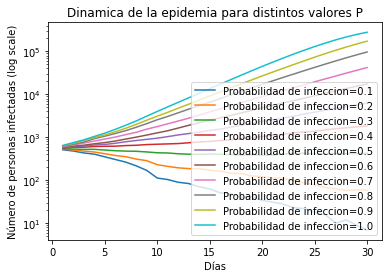

In [ ]:
#interactive plotting in separate window
plt.figure(2)
#%matplotlib qt 
for i in range(len(results)):
  plt.plot(range(1,250+1)[:30], results[i][1][:30], label=f'Probabilidad de infeccion={(i+1)/10}')
plt.xlabel('Días')
plt.ylabel('Número de personas infectadas (log scale)')
plt.title('Dinamica de la epidemia para distintos valores P')
plt.yscale("log")
plt.legend()
plt.show()


Text(0, 0.5, 'Fraccion de recuperados')

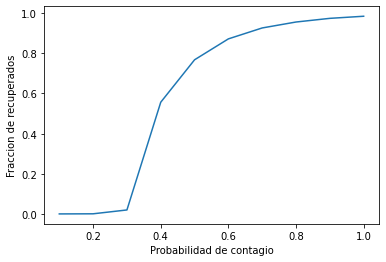

In [ ]:
recuperados=[results[i][2][-1] for i in range(len(results))]
recuperados
plt.figure(5)
plt.plot(np.arange(0.1,1.1,0.1),np.array(recuperados)/600000)
plt.xlabel('Probabilidad de contagio')
plt.ylabel('Fraccion de recuperados')

In [ ]:
def R_0(p=1):
    from tqdm import tqdm
    lista=np.zeros(10000)
    for s in tqdm(range(10000)):
        #Defino el vector de estados
        estados=np.zeros(N)
        #np.random.seed(0)
        inf_in=np.random.choice(N, size=1)[0]

        estados[inf_in]=1

        #Defino el vector de infectados, sus elementos son sublistas con primer elemento id y segundo elemento numero de dia cursando la 
        #enfermedad
        infectados=[[inf_in, 1, None] ]

        dias=10
        t_inf=10

        #n_suc=np.zeros(dias)
        #n_inf=np.zeros(dias)
        #n_rec=np.zeros(dias)
        #estado=np.zeros([dias,N])

        for dia in range(dias): #loop para los dias de simulacion
            nuevos=[]
            for inf in infectados: #loop para recorrer los infectados inf
                casa=inf[0]//4 #Defino la casa en la que vive el infectado
                for i in casas[casa]: #agregar probabilidad, aca estoy supoineindo p=1
                    if estados[i]==0:
                        prob_c=1-np.exp(-p*dur_1(inf[0],i,m_edad)/(1440))
                        random_c=np.random.random()
                        if random_c < prob_c:
                            nuevos.append([i,1,inf[0]])
                            estados[i]=1
                if edad[inf[0]]==0:
                    busco=np.where(escuelas==inf[0])
                    escuela=busco[0][0]
                    persona=np.where(escuelas==inf[0])[1][0]
                    for index, contacto in enumerate(escuelas[escuela]):
                        if estados[contacto]==0:
                            prob_es=1-np.exp(-p*m_esc[escuela,persona, index])
                            random_es=np.random.random()
                            if random_es < prob_es:
                                nuevos.append([contacto,1,inf[0]])
                                estados[contacto]=1
                else:
                    busco=np.where(trabajos==inf[0])
                    trabajo=busco[0][0]
                    persona=busco[1][0]
                    for index, contacto in enumerate(trabajos[trabajo]):
                        if estados[contacto]==0:
                            prob_tr=1-np.exp(-p*m_tra[trabajo,persona, index])
                            random_tr=np.random.random()
                            if random_tr < prob_tr:
                                nuevos.append([contacto,1,inf[0]])
                                estados[contacto]=1

                resto=dur_3(inf[0]) #[(2, 11324), (5, 21544), (5, 4448), (2, 1933)]
                for k,l in resto:
                    #print(resto)
                    if estados[l]==0:
                        prob_r=1-np.exp(-(p*k)/1440)
                        random_r=np.random.random()
                        if random_r < prob_r:
                            nuevos.append([l,1,inf[0]])
                            estados[l]=1
                inf[1]=inf[1]+1
                if inf[1]>t_inf: #cambiar 10 por t_inf
                    estados[inf[0]]=2 #pasa a recuperado
                    #del inf #sacalo del vector de infectados
            infectados[:]=[inf for inf in infectados if not inf[1]>t_inf]
            infectados=infectados+nuevos
            #print(infectados)
            #n_suc[dia]=np.sum(estados==0)
            #n_inf[dia]=np.sum(estados==1)
            #n_rec[dia]=np.sum(estados==2)
            #estado[dia]=estados
        R_0=np.sum([i[2] for i in infectados]==inf_in)
        lista[s]=R_0
    return np.mean(lista)
        

In [ ]:
lista_R_0=[]
for p in np.arange(0,1.1,0.05):
    lista_R_0.append([R_0(p)])

In [ ]:
np.save('lista_R0.npy', lista_R_0)

In [ ]:
lista_R0=np.load('lista_R0.npy')
len(lista_R0)

22

In [ ]:
lista_R_0=np.array(lista_R_0).reshape(22)

In [ ]:
lista_R_0_drive=np.array(lista_R_0_drive)

In [ ]:
plt.figure(3)
plt.plot(np.arange(0,1.1,0.05),lista_R0)
plt.xlabel('Valores de la probabilidad P de contagio')
plt.ylabel('Valores de R0')

Text(0, 0.5, 'Valores de R0')

In [ ]:
from sklearn.linear_model import LinearRegression
x=np.arange(1,dias+1)[:28].reshape(-1,1)
y=np.log(n_inf)[:28]
model=LinearRegression().fit(x,y)

In [ ]:
model.coef_

$\frac{dS}{dt}=